## 数据预处理

由于所使用的数据集猫狗分类是混合在一起的，没有进行分类。数据集的文件以category.no.jpg方式命名，例如dog.9999.jpg。

训练集中的命名方式也不仅仅通过递增的序号，而是以树的形式。
例如：
```
├── dog.93.jpg
├── dog.94.jpg
│   └── ...
└── dog.95.jpg
    ├── dog.951.jpg 
    └── dog.952.jpg 
        └── dog.9521.jpg
```

这里我们对文件进行预处理，将训练集分成cat和dog两个文件夹。

最终目录结构如下所示：

```
├── train2
│   └── dog
│   │   ├── dog.0.jpg 
│   │   ├── ... 
│   │   └── dog.12499.jpg 
│   └── cat
│       ├── cat.0.jpg 
│       ├── ... 
│       └── cat.12499.jpg
└── test2
    └── test
        ├── cat.1.jpg 
        ├── ...
        └── cat.12500.jpg
```

## 导入Lib库

In [2]:
import os
import cv2
import h5py
import numpy as np
from sklearn.utils import shuffle
import pandas as pd           
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
import random
from tqdm import tqdm
%matplotlib inline   

/home/mj/.conda/envs/ten/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 数据探索

In [2]:
!echo "cats | $(find imgs/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find imgs/train/ -name 'dog*' | wc -l)"

cats | 12500
dogs | 12500


In [3]:
#显示数据
import os
import shutil

##read images names
train_filenames = os.listdir('imgs/train')
train_cat = [img for img in filter(lambda x:x[:3] == 'cat', train_filenames)]
train_dog = [img for img in filter(lambda x:x[:3] == 'dog', train_filenames)]


train_total = np.concatenate((train_cat,train_dog))

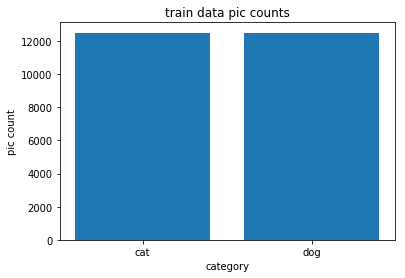

In [4]:
x =np.array([len(train_cat),len(train_dog)])
plt.bar(['cat','dog'],[x[0],x[1]])
plt.xlabel('category')
plt.ylabel('pic count')
plt.title('train data pic counts')
plt.show()

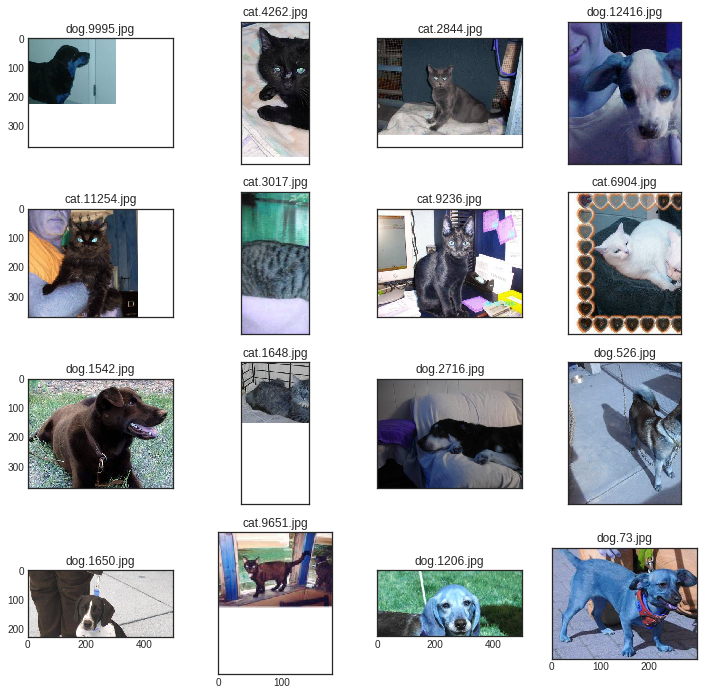

In [5]:
plt.style.use('seaborn-white')
random.seed(42)
#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))

#随机获取图片
for i in range(4):
    for j in range(4):
        #随机获取图片
        ran = random.randint(0,25000)
        img = cv2.imread("imgs/train/%s" % train_total[ran])
        ax[i,j].set_title('%s'% train_total[ran])
        ax[i,j].imshow(img)

In [6]:
## 现实所有图片尺寸
type(train_total)
def get_shape(img_arr:np.ndarray)-> tuple:
    shape_list = []
    for index in img_arr:
        img = cv2.imread("imgs/train/%s" % index)
        shape_list.append([img.shape[0],img.shape[1]])
    return (shape_list)
    
shape_list = get_shape(train_total)

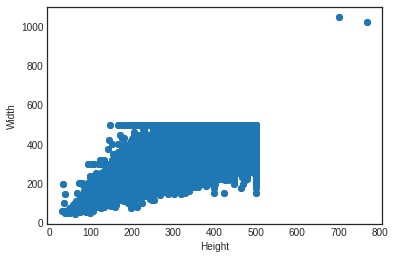

In [7]:
# 绘制散点分布图
x_index = [i[0] for i in shape_list]
y_index = [i[1] for i in shape_list]

plt.scatter(x_index,y_index)
plt.xlabel('Height')
plt.ylabel('Width')
plt.plot(x_index,y_index,'o')
plt.show()

## 采用预处理模型剔除异常数据


In [8]:
img_size = (299, 299)
## 载入预先下载好的ImageNet分类csv文件
import csv
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

def get_imageNet_class(file_path:str)->tuple:
    category_class = []
    with open(file_path,'r') as f:
        reader = csv.reader(f)
        for line in reader:
            if(line[1] == '猫') or (line[1] == '狗'):
                category_class.append(line[0])
    return (category_class)

def conv_img_path(img_arr:np.ndarray)->tuple:
    dir_path = []
    for i in train_total:
        dir_path.append('imgs/train/%s' % i)
    return (dir_path)

def read_image(img_path:str)->tuple:
    img = image.load_img('%s' % img_path,target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return (x)

def read_image_dir(dir_list:list)->tuple:
    preprocess_imgs = [read_image(fp) for fp in tqdm(dir_arr)]
    return (preprocess_imgs)

imageNet_class = get_imageNet_class('ImageNetClasses.csv')

#转换路径
dir_arr = conv_img_path(train_total)
#获取归一化后图片
preprocess_imgs = read_image_dir(dir_arr)
    

 20%|█▉        | 4881/25000 [00:09<00:40, 491.56it/s]/home/mj/.conda/envs/ten/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 25000/25000 [00:51<00:00, 488.15it/s]


In [38]:
from keras.applications.inception_v3 import decode_predictions

def predict_model(model,imgs,top = 10):
    pred = model.predict(imgs)
    return (decode_predictions(pred,top=top)[0])

def get_predict(model,imgs,top=10):
    result = [ predict_model(model, x, top) for x in tqdm(imgs) ]
    return(result)
        
model= InceptionV3(weights='imagenet')

##预测模型
pred = get_predict(model, preprocess_imgs, 50)

  2%|▏         | 462/25000 [00:09<08:45, 46.69it/s]/home/mj/.conda/envs/ten/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 25000/25000 [07:43<00:00, 53.89it/s]


26


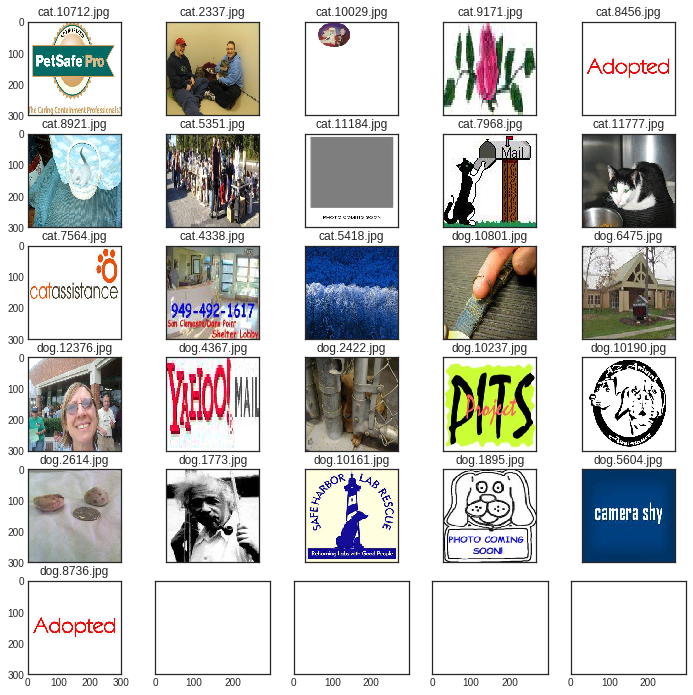

In [39]:
# 获取能match到猫狗类型的预测总数
def get_result_list(pred):
    result = []
    for item in pred:
        pred_list = [ x[0] for x in item ]
        pred_list = [ 1 for x in pred_list if x in imageNet_class ]
        result.append(sum(pred_list))
    return(right_list)

# 获取异常数据的文件名
right_list = get_right_list(pred)
exp_flist = []
for index, value in enumerate(right_list):
    if value == 0:
        exp_flist.append(train_total[index])
        

plt.style.use('seaborn-white')
#查看图片内容
fig,ax = plt.subplots(6,5,sharex='col',sharey='row',figsize=(12,12))

print (len(exp_flist))
index = 0
for i in range(5):
    for j in range(5):
        img = image.load_img("imgs/train/%s" % exp_flist[index],target_size=img_size)
        ax[i,j].set_title('%s'% exp_flist[index])
        ax[i,j].imshow(img)
        index+=1
#最后一张
img = image.load_img("imgs/train/%s" % exp_flist[-1],target_size=img_size)
ax[5,0].set_title('%s'% exp_flist[-1])
ax[5,0].imshow(img)

- 从上图中通过预训练模型对图片筛选出异常的图片
- 再结合人工筛选进一步筛选图片

比如：
1. cat.8921.jpg，cat.11777.jpg，dog.2422.jpg,cat.2337.jpg分类正确，不需要排除。

同时添加，人工过滤的图片。
1. cat.7377.jpg, cat.4085.jpg


In [57]:
#剔除异常值
exp_arr = np.array(exp_flist)
nor_arr = np.array(['cat.8921.jpg','cat.11777.jpg','cat.2337.jpg'])
manual_arr = np.array(['cat.92.jpg','cat.7377.jpg','cat.4085.jpg'])

need_delete_arr = []
for file_name in exp_arr:
    if file_name not in nor_arr:
        need_delete_arr.append(file_name)
        
need_delete_arr = np.concatenate((np.array(need_delete_arr),np.array(manual_arr)))
need_delete_arr 

array(['cat.10712.jpg', 'cat.10029.jpg', 'cat.9171.jpg', 'cat.8456.jpg',
       'cat.5351.jpg', 'cat.11184.jpg', 'cat.7968.jpg', 'cat.7564.jpg',
       'cat.4338.jpg', 'cat.5418.jpg', 'dog.10801.jpg', 'dog.6475.jpg',
       'dog.12376.jpg', 'dog.4367.jpg', 'dog.2422.jpg', 'dog.10237.jpg',
       'dog.10190.jpg', 'dog.2614.jpg', 'dog.1773.jpg', 'dog.10161.jpg',
       'dog.1895.jpg', 'dog.5604.jpg', 'dog.8736.jpg', 'cat.92.jpg',
       'cat.7377.jpg', 'cat.4085.jpg'], dtype='<U13')

In [60]:
#删除操作
for file_name in need_delete_arr:
    path = 'imgs/train/%s' %file_name
    if os.path.exists(path):
        os.remove(path)
    else:
        print ('no such file:%s'% file_name)

In [65]:
#删除后统计图片张数
print(len(need_delete_arr))
!echo "cats | $(find imgs/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find imgs/train/ -name 'dog*' | wc -l)"

26
cats | 12487
dogs | 12487


In [67]:
after_delete_train_cat = [img for img in filter(lambda x:x[:3] == 'cat', train_filenames)]
after_delete_train_dog = [img for img in filter(lambda x:x[:3] == 'dog', train_filenames)]

def build_mkdir(dirname):
    if os.path.exists(dirname):
        #delete old direct
        shutil.rmtree(dirname)
    os.mkdir(dirname)

build_mkdir('imgs/train2')
os.mkdir('imgs/train2/cat')
os.mkdir('imgs/train2/dog')

#copy files to new path
def copy_to_newPath(oldPath:str,newPath:str,imgName:list)->None:
    for img in imgName:
        pathA = oldPath + img
        pathB = newPath + img
        shutil.copyfile(pathA,pathB)
        
copy_to_newPath('imgs/train/','imgs/train2/cat/',after_delete_train_cat)
copy_to_newPath('imgs/train/','imgs/train2/dog/',after_delete_train_dog)


## 加载数据集
猫狗大战数据集：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [3]:
train_path = "imgs/train2"
test_path = "imgs/test2"

img_size = (299, 299)

gen = ImageDataGenerator()
X_train_gen = gen.flow_from_directory(train_path, img_size, shuffle = False, 
                                        batch_size = 16)
X_test_gen = gen.flow_from_directory(test_path, img_size, shuffle = False, 
                                        batch_size = 16, classes = None)

Found 24974 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 构建模型

In [4]:
#基础模型
input_tensor = Input((img_size[0], img_size[1], 3))
input_tensor = Lambda(inception_v3.preprocess_input)(input_tensor)
base_model = InceptionV3(input_tensor = input_tensor, 
                             weights = 'imagenet', include_top = False)
base_model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

## 使用预训练模型预测图像

In [5]:
X_train = base_model.predict_generator(X_train_gen, verbose=1)
X_test = base_model.predict_generator(X_test_gen, verbose=1)

782/782 [==============================] - 62s 79ms/step


## 保存特征的权重

In [6]:
with h5py.File('saved_models/weights.inv3.hdf5') as fp:
        fp.create_dataset('train', data = X_train)
        fp.create_dataset('test', data = X_test)
        fp.create_dataset('label', data = X_train_gen.classes)

## 导入保存的权重

In [7]:
X_train = []
X_test = []
with h5py.File('saved_models/weights.inv3.hdf5', 'r') as fp:
    X_train.append(np.array(fp['train']))
    X_test.append(np.array(fp['test']))
    y_train = np.array(fp['label'])
    
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_train, y_train = shuffle(X_train, y_train)

## 增加全连接层和dropout层

In [28]:
input_tensor = Input(X_train.shape[1:])
inception_v3_model = Model(input_tensor, Dropout(0.2)(input_tensor))
inception_v3_model = Model(inception_v3_model.input, Dense(1, activation = 'sigmoid')(inception_v3_model.output))
inception_v3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


## 编译模型

In [29]:
inception_v3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [30]:
epochs = 10
batch_size = 128
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inv3.hdf5', 
                                   verbose=1, save_best_only=True)
history_tarin = inception_v3_model.fit(X_train, y_train, validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose=1,
                    callbacks=[checkpointer])

Train on 19979 samples, validate on 4995 samples
Epoch 1/10
19979/19979 [==============================] - 1s 41us/step - loss: 0.1336 - acc: 0.9603 - val_loss: 0.0412 - val_acc: 0.9914

Epoch 00001: val_loss improved from inf to 0.04118, saving model to saved_models/weights.best.inv3.hdf5
Epoch 2/10
19979/19979 [==============================] - 0s 15us/step - loss: 0.0343 - acc: 0.9919 - val_loss: 0.0271 - val_acc: 0.9938

Epoch 00002: val_loss improved from 0.04118 to 0.02712, saving model to saved_models/weights.best.inv3.hdf5
Epoch 3/10
19979/19979 [==============================] - 0s 18us/step - loss: 0.0260 - acc: 0.9931 - val_loss: 0.0221 - val_acc: 0.9942

Epoch 00003: val_loss improved from 0.02712 to 0.02212, saving model to saved_models/weights.best.inv3.hdf5
Epoch 4/10
19979/19979 [==============================] - 0s 22us/step - loss: 0.0226 - acc: 0.9936 - val_loss: 0.0202 - val_acc: 0.9944

Epoch 00004: val_loss improved from 0.02212 to 0.02018, saving model to saved_m

## 学习曲线

学习曲线的特征包含以下3点：
- 特定复杂度的模型对较小的数据集容易过拟合：此时训练得分较高，验证得分较低。
- 特定复杂度的模型对交大的数据集容易欠拟合：随着数据的增大，训练得分会不断降低，而验证集的得分会不断升高。
- 模型的验证集得分永远不会高于训练集得分，两条曲线会一直在靠近，但是永远不会交叉。

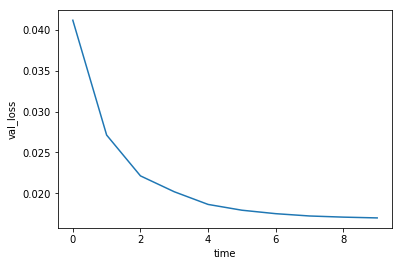

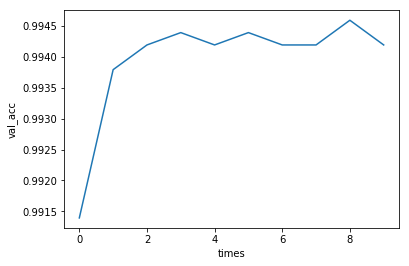

In [31]:
plt.plot(history_tarin.history['val_loss'])
plt.xlabel('time')
plt.ylabel('val_loss')
plt.show()

plt.plot(history_tarin.history['val_acc'])
plt.xlabel('times')
plt.ylabel('val_acc')
plt.show()

## 调整模型参数优化模型
- 我们通过调整模型参数来对模型进行优化
- 同时利用默认的参数进行对比决定所选参数术后合理。

### 尝试不同的dropout保留率
尝试范围0.1-0.9

In [28]:
epochs = 10
batch_size = 128

dropout_info = []

def modify_dropout_rate(rate):
    input_tensor = Input(X_train.shape[1:])
    inception_v3_model = Model(input_tensor, Dropout(rate)(input_tensor))
    inception_v3_model = Model(inception_v3_model.input, Dense(1, activation = 'sigmoid')(inception_v3_model.output))
    
    inception_v3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history_tarin = inception_v3_model.fit(X_train, y_train, validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose=1)
    
    return (rate,history_tarin.history['val_loss'],history_tarin.history['val_acc'])

dropout_result= []
for rate in np.arange(0.1,1,0.1):
    rate_data=  modify_dropout_rate(round(rate,1))
    dropout_result.append(rate_data)

Train on 19979 samples, validate on 4995 samples
Epoch 1/10
19979/19979 [==============================] - 1s 47us/step - loss: 0.1157 - acc: 0.9696 - val_loss: 0.0388 - val_acc: 0.9924
Epoch 2/10
19979/19979 [==============================] - 0s 17us/step - loss: 0.0311 - acc: 0.9926 - val_loss: 0.0276 - val_acc: 0.9924
Epoch 3/10
19979/19979 [==============================] - 0s 17us/step - loss: 0.0236 - acc: 0.9935 - val_loss: 0.0237 - val_acc: 0.9926
Epoch 4/10
19979/19979 [==============================] - 1s 25us/step - loss: 0.0201 - acc: 0.9940 - val_loss: 0.0220 - val_acc: 0.9928
Epoch 5/10
19979/19979 [==============================] - 1s 25us/step - loss: 0.0183 - acc: 0.9947 - val_loss: 0.0218 - val_acc: 0.9924
Epoch 6/10
19979/19979 [==============================] - 1s 29us/step - loss: 0.0175 - acc: 0.9946 - val_loss: 0.0209 - val_acc: 0.9930
Epoch 7/10
19979/19979 [==============================] - 0s 20us/step - loss: 0.0159 - acc: 0.9949 - val_loss: 0.0207 - val_acc:

In [60]:
## dropout rate and val_loss
pd_data = []
for index in range(len(dropout_result)):
    row = []
    avg_value = np.average(dropout_result[index][1])
    max_value = np.max(dropout_result[index][1])
    min_value = np.min(dropout_result[index][1])
    row.append(avg_value)
    row.append(max_value)
    row.append(min_value)
    pd_data.append(row)

val_loss_df = pd.DataFrame(
    data=pd_data,
    index=['0.1', '0.2', '0.3', '0.4', '0.5',
           '0.6', '0.7', '0.8', '0.9'],
    columns=['Avg', 'Max', 'Min']
)
val_loss_df.index.name = 'dropout rate'
val_loss_df

Avg       Max       Min
droupout rate                              
0.1            0.023771  0.038840  0.020481
0.2            0.023003  0.035460  0.019824
0.3            0.023591  0.038748  0.020342
0.4            0.025762  0.045979  0.020318
0.5            0.024320  0.040121  0.020563
0.6            0.024787  0.039904  0.021356
0.7            0.024945  0.041661  0.020169
0.8            0.026067  0.045350  0.021988
0.9            0.030635  0.052847  0.024387

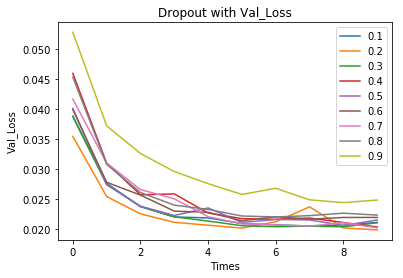

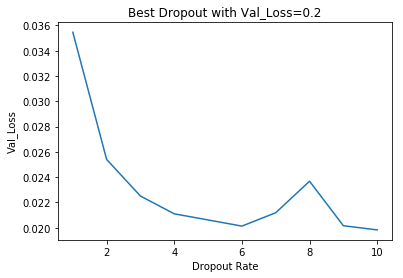

In [96]:
## dropout rate and val_loss

for index in range(len(dropout_result)):
    plt.plot(dropout_result[index][1],label=dropout_result[index][0])

plt.title('Dropout with Val_Loss')
plt.xlabel('Times')
plt.ylabel('Val_Loss')
plt.legend()
plt.show() 


## best dropout 0.2
plt.title('Best Dropout with Val_Loss=0.2')
plt.plot(np.arange(1,11,1),[x for x in dropout_result[1][1]])
plt.xlabel('Dropout Rate')
plt.ylabel('Val_Loss')
plt.show()

上图可以看出dropout=0.2 val_loss最小。因此将之前的dropout0.5改为0.2。

## 预测测试集

In [11]:
y_pred = inception_v3_model.predict(X_test)
y_pred = y_pred.clip(min = 0.005, max = 0.995)

In [12]:
num = [ int(re.sub('.jpg', '', re.sub('.*\/', '', f))) for f in X_test_gen.filenames ]
df = pd.read_csv("sample_submission.csv")
for i in range(len(num)):
    df.set_value(num[i] - 1, 'label', y_pred[i])
df.to_csv('pred.csv', index=None)
df.head(10)

/home/mj/.conda/envs/ten/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005